In [303]:
%matplotlib inline
import sys
sys.path.append("src") # add the source dir

In [304]:
import matplotlib.pyplot as plt
import os
from src.pipeline import Pipeline, MultiPipeline
from mne_bids import BIDSPath
import mne

## We will do an individual Analysis of subject 30, afterthat, we will statistically check all the other subject

In [305]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',datatype='eeg', suffix='eeg', root=bids_root)
pipeline = Pipeline(bids_path)

In [306]:
from preprocessing import CleaningData, SimpleMNEFilter, PrecomputedICA

pipeline.load_data()
pipeline.set_montage()
pipeline.set_custom_events_mapping(task='P3')

INFO:root:Loading Data
INFO:root:Standard 1020 montage and EOG channels are set


### We will use our pipeline to perform following operations
- Loading bad segments, bad channels
- Apply filtering
- Loading Precomputed ICA

In [307]:
pipeline.make_pipeline([CleaningData(bids_path), SimpleMNEFilter(0.5, 50, 'firwin'), PrecomputedICA(bids_path)])

INFO:root:*****Proceesing for subject: 030*****
INFO:root:Applying cleaning
INFO:root:Applying filtering
INFO:root:Applying ICA
INFO:root:Processed subject 030



In [308]:
pipeline.raw.annotations

<Annotations | 481 segments: BAD_asrAutoDetect (79), response/correct/201 ...>

In [309]:
pipeline.apply_rereferencing('average')
pipeline.apply_resampling(512)

INFO:root:Applying re-referencing
INFO:root:Applying resampling


# ERP Peak Analysis

In [310]:
from erpanalysis import ERPAnalysis
tmin = -0.1
tmax = 0.8
baseline = (None, 0)


## We will create epochs from custom mappings, where,

- Stimulus: A, B, C, D, E

- Conditions: Rare, Frequent

In [311]:
erp = ERPAnalysis(tmin, tmax)
erp.compute_epochs(pipeline.raw, pipeline.events, pipeline.event_ids, baseline=baseline, reject_by_annotation=True)

<Epochs |  402 events (good & bad), -0.0996094 - 0.800781 sec, baseline -0.0996094 – 0 sec, ~49 kB, data not loaded,
 'response/correct/201': 193
 'response/error/202': 9
 'stimulus/A/freq/12': 4
 'stimulus/A/freq/13': 10
 'stimulus/A/freq/14': 9
 'stimulus/A/freq/15': 9
 'stimulus/A/rare/11': 8
 'stimulus/B/freq/21': 6
 'stimulus/B/freq/23': 12
 'stimulus/B/freq/24': 3
 'stimulus/B/freq/25': 11
 'stimulus/B/rare/22': 8
 'stimulus/C/freq/31': 8
 'stimulus/C/freq/32': 10
 'stimulus/C/freq/34': 4
 'stimulus/C/freq/35': 10
 'stimulus/C/rare/33': 8
 'stimulus/D/freq/41': 7
 'stimulus/D/freq/42': 12
 'stimulus/D/freq/43': 11
 'stimulus/D/freq/45': 2
 'stimulus/D/rare/44': 8
 'stimulus/E/freq/51': 8
 'stimulus/E/freq/52': 12
 'stimulus/E/freq/53': 4
 'stimulus/E/freq/54': 8
 'stimulus/E/rare/55': 8>

## Analysis Epochs

In [312]:
rare_epochs = erp.epochs['rare']
freq_epochs = erp.epochs['freq']

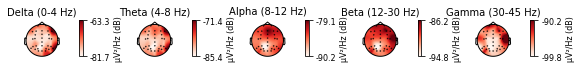

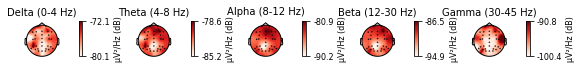

In [313]:
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 4));
rare_epochs.plot_psd_topomap(axes = axs);
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 4));
freq_epochs.plot_psd_topomap(axes = axs);

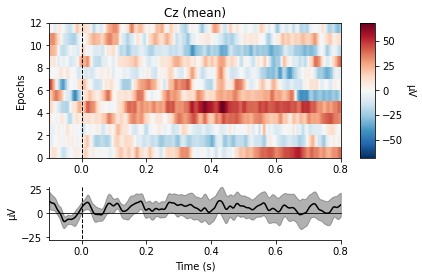

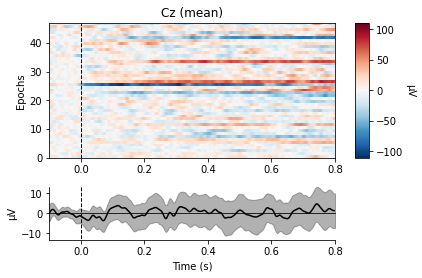

In [314]:
rare_epochs.plot_image(picks=['Cz'], combine='mean');
freq_epochs.plot_image(picks=['Cz'], combine='mean');

## Analysis Evokeds

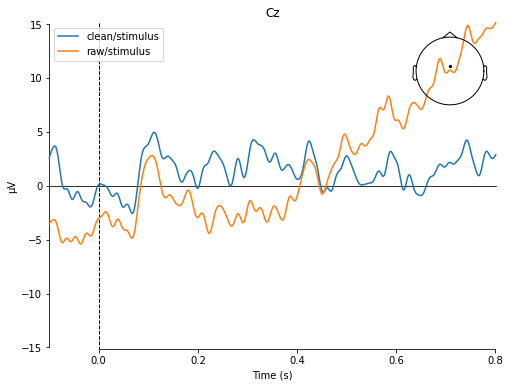

[<Figure size 576x432 with 2 Axes>]

In [315]:
epochs_raw = erp.compute_epochs(pipeline.raw, pipeline.events, pipeline.event_ids, set_default=False, reject_by_annotation=False)
epochs_clean = erp.epochs.copy()
evoked_raw = epochs_raw['stimulus'].average()
evoked_clean = epochs_clean['stimulus'].average()
mne.viz.plot_compare_evokeds({'clean/stimulus': evoked_clean,'raw/stimulus': evoked_raw}, picks="Cz")

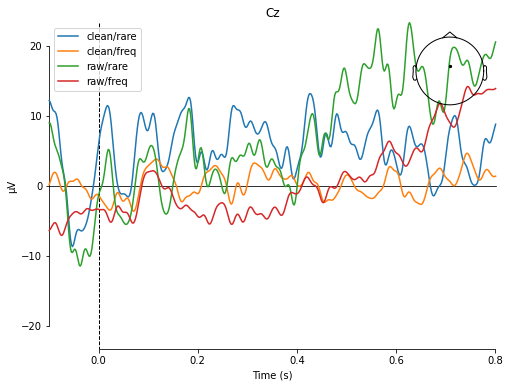

[<Figure size 576x432 with 2 Axes>]

In [316]:
mne.viz.plot_compare_evokeds({'clean/rare': epochs_clean['rare'].average(),
'clean/freq': epochs_clean['freq'].average(),
'raw/rare':epochs_raw['rare'].average(),
'raw/freq': epochs_raw['freq'].average(),
},picks="Cz")

In [317]:
evoked_rare = epochs_clean['rare'].average()
evoked_freq = epochs_clean['freq'].average()

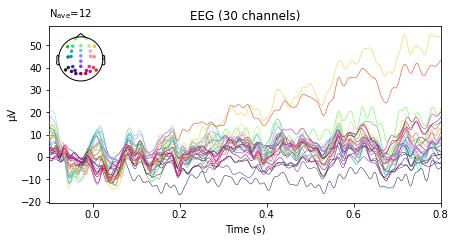

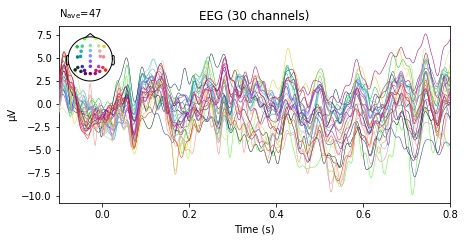

In [318]:
evoked_rare.plot(spatial_colors=True);
evoked_freq.plot(spatial_colors=True);

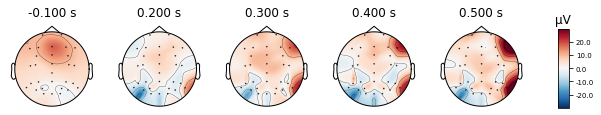

In [319]:
evoked_rare.plot_topomap(times=[-0.1, 0.2, 0.3, 0.4, 0.5], average=0.05);

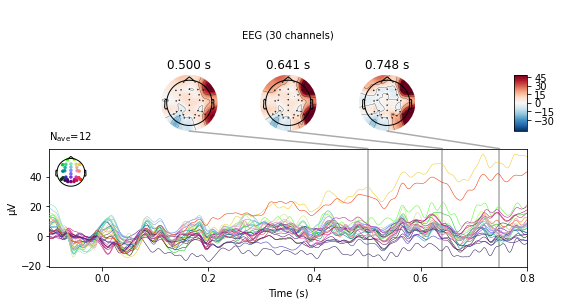

In [320]:
evoked_rare.plot_joint();

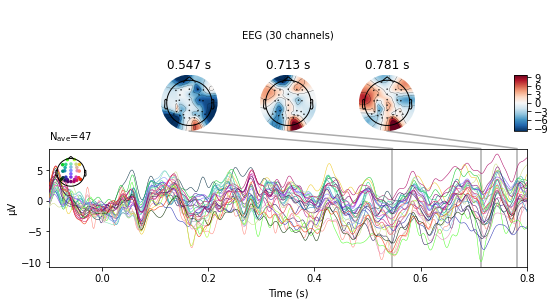

In [321]:
evoked_freq.plot_joint();

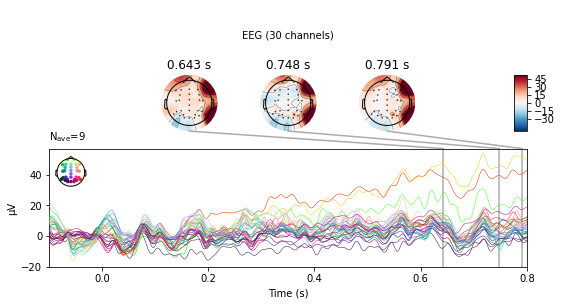

In [322]:
rare_minus_freq = mne.combine_evoked([evoked_rare, evoked_freq], weights=[1, -1])
rare_minus_freq.plot_joint();

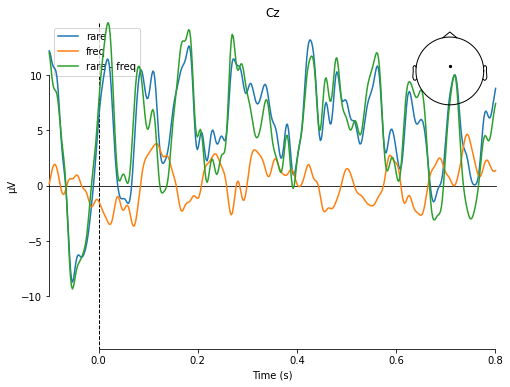

[<Figure size 576x432 with 2 Axes>]

In [323]:
mne.viz.plot_compare_evokeds({'rare': evoked_rare,'freq': evoked_freq, 'rare - freq': rare_minus_freq}, picks=["Cz"])

## It seems it is futile to check for condition on each subject since, the number of events in epochs drop downs to a range between 0,5. There is a possiblity that we might be getting futile results

In [324]:
pipelines = MultiPipeline(bids_root)
erp = ERPAnalysis(tmin, tmax, baseline=(None, 0), reject_by_annotation=True, all_subjects=True)
pipelines.start_erp_analysis(erp);

100%|██████████| 40/40 [00:46<00:00,  1.15s/it]


In [325]:
len(erp.epochs)

40

In [326]:
def plt_all_subjects(_epochs, ax, sub_id):
    mne.viz.plot_compare_evokeds({'rare': _epochs['rare'].average(),'freq':_epochs['freq'].average()},axes=ax, title='Subject {}'.format(sub_id), picks="Cz")

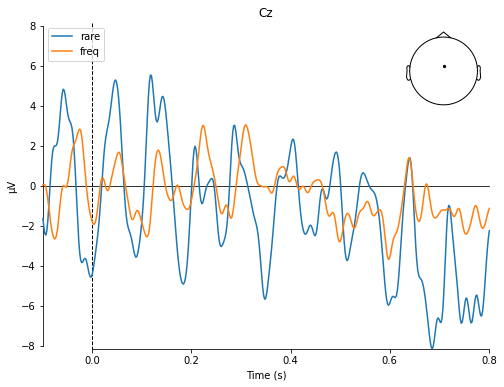

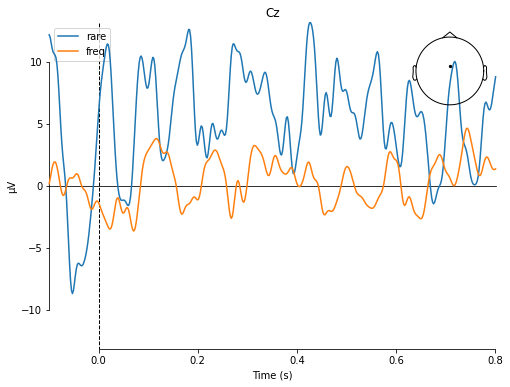

[<Figure size 576x432 with 2 Axes>]

In [327]:
mne.viz.plot_compare_evokeds({'rare': erp.epochs[38]['rare'].average(),'freq':erp.epochs[38]['freq'].average()},picks="Cz")
mne.viz.plot_compare_evokeds({'rare': epochs_clean['rare'].average(),'freq':epochs_clean['freq'].average()},picks="Cz")

In [328]:
def test():
    import numpy as np
    blocks = np.array([ list(range(10*x + 1, 10*x + 6)) for x in range(1, 6)])
    rare = np.array([ x + i for i, x in enumerate(range(11, 56, 10))]).tolist()
    freq = np.setdiff1d(blocks.flatten(), rare).tolist()
    stimlus = ['A', 'B', 'C', 'D', 'E']
    evts_stim = pipeline.event_ids
    rare = [k for k in evts_stim.keys() if k.split('/')[1] == 'rare']
    freq = [k for k in evts_stim.keys() if k.split('/')[1] == 'freq']
    rare_dict = dict((k, pipeline.event_ids[k]) for k in rare)
    freq_dict = dict((k, pipeline.event_ids[k]) for k in freq)

    rare_epochs = mne.Epochs(pipeline.raw,pipeline.events, rare_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
    freq_epochs = mne.Epochs(pipeline.raw,pipeline.events, freq_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
    mne.viz.plot_compare_evokeds({'rare': rare_epochs.average(), 'freq': freq_epochs.average()}, picks='Cz')

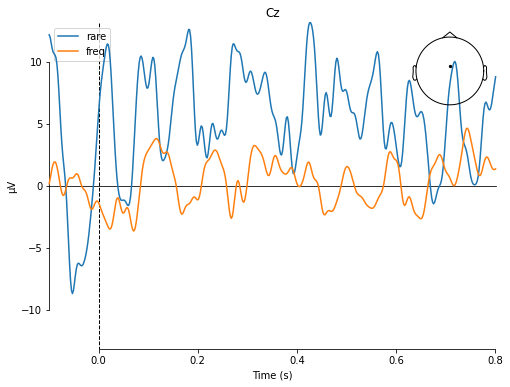

[<Figure size 576x432 with 2 Axes>]

In [329]:
mne.viz.plot_compare_evokeds({'rare': epochs_clean['rare'].average(),'freq':epochs_clean['freq'].average()},picks="Cz")

# ERP Peak Analysis

In [330]:
len(erp.epochs)
rare_peaks_df = erp.compute_peak('rare', 0.35, 0.1, ['Cz'])
freq_peaks_df = erp.compute_peak('freq', 0.35, 0.1, ['Cz'])


In [331]:
import pandas as pd
rare_df = pd.concat(rare_peaks_df, ignore_index=True)
freq_df = pd.concat(freq_peaks_df, ignore_index=True)
rare_df.describe()

peak_amp    mean_amp     latency       trial
count  657.000000  657.000000  657.000000  657.000000
mean    13.993912    0.260274  345.468798    8.234399
std     11.928648    9.733217   62.725321    5.405212
min    -50.000000  -67.000000  250.000000    0.000000
25%      6.000000   -5.000000  287.000000    4.000000
50%     13.000000    0.000000  342.000000    8.000000
75%     20.000000    5.000000  404.000000   13.000000
max     79.000000   47.000000  447.000000   21.000000

In [332]:
freq_df.describe()

peak_amp     mean_amp      latency        trial
count  2565.000000  2565.000000  2565.000000  2565.000000
mean     13.708382    -0.095906   349.738791    33.313060
std      11.693863     9.408116    63.288197    20.890208
min     -56.000000   -85.000000   250.000000     0.000000
25%       6.000000    -6.000000   293.000000    16.000000
50%      13.000000     0.000000   352.000000    32.000000
75%      20.000000     5.000000   406.000000    50.000000
max      84.000000    59.000000   447.000000    80.000000

In [333]:
peak_df = pd.concat([rare_df, freq_df], ignore_index=True)

<AxesSubplot:xlabel='latency', ylabel='Density'>

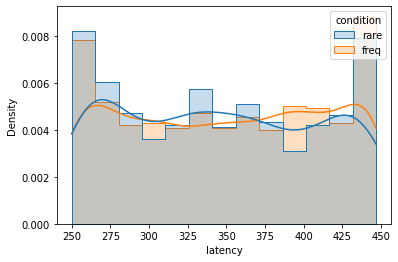

In [334]:
import seaborn as sns
sns.histplot(peak_df, x='latency', hue='condition', kde=True, element="step",
    stat="density", common_norm=False)

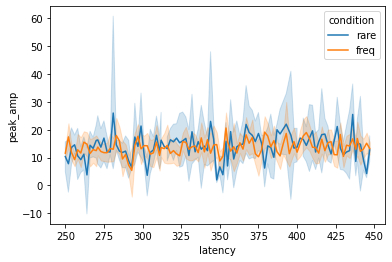

In [335]:
ax = sns.lineplot(x="latency", y="peak_amp", data=peak_df, hue='condition')

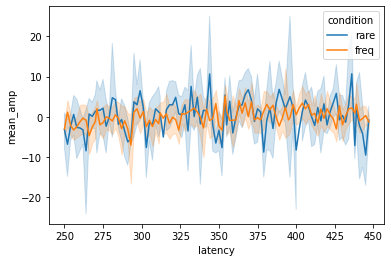

In [336]:
ax = sns.lineplot(x="latency", y="mean_amp", data=peak_df, hue='condition')

In [337]:
A_rare_peaks = pd.concat(erp.compute_peak('A/rare', 0.35, 0.2, ['Cz']), ignore_index=True)
A_freq_peaks = pd.concat(erp.compute_peak('A/freq', 0.35, 0.2, ['Cz']), ignore_index=True)
B_rare_peaks = pd.concat(erp.compute_peak('B/rare', 0.35, 0.2, ['Cz']), ignore_index=True)
B_freq_peaks = pd.concat(erp.compute_peak('B/freq', 0.35, 0.2, ['Cz']), ignore_index=True)
C_rare_peaks = pd.concat(erp.compute_peak('C/rare', 0.35, 0.2, ['Cz']), ignore_index=True)
C_freq_peaks = pd.concat(erp.compute_peak('C/freq', 0.35, 0.2, ['Cz']), ignore_index=True)
D_rare_peaks = pd.concat(erp.compute_peak('D/rare', 0.35, 0.2, ['Cz']), ignore_index=True)
D_freq_peaks = pd.concat(erp.compute_peak('D/freq', 0.35, 0.2, ['Cz']), ignore_index=True)
E_rare_peaks = pd.concat(erp.compute_peak('E/rare', 0.35, 0.2, ['Cz']), ignore_index=True)
E_freq_peaks = pd.concat(erp.compute_peak('E/freq', 0.35, 0.2, ['Cz']), ignore_index=True)


In [338]:
all_peaks = pd.concat([
A_rare_peaks,
A_freq_peaks,
B_rare_peaks,
B_freq_peaks,
C_rare_peaks,
C_freq_peaks,
D_rare_peaks,
D_freq_peaks,
E_rare_peaks,
E_freq_peaks,
], ignore_index=True)

In [339]:
all_peaks.describe()


peak_amp     mean_amp      latency        trial
count  3222.000000  3222.000000  3222.000000  3222.000000
mean     17.225636    -0.057728   349.033209    10.166977
std      11.745978     8.759352   125.326910     8.472615
min     -56.000000   -83.000000   150.000000     0.000000
25%      10.000000    -5.000000   234.000000     3.000000
50%      16.000000     0.000000   352.000000     8.000000
75%      23.000000     5.000000   463.000000    16.000000
max      93.000000    56.000000   549.000000    31.000000

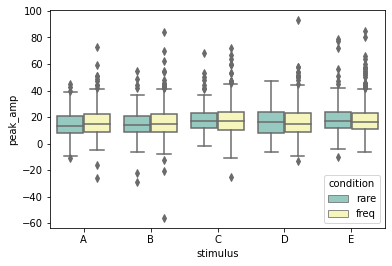

In [340]:
ax = sns.boxplot(x="stimulus", y="peak_amp", hue="condition",  data=all_peaks, palette="Set3")

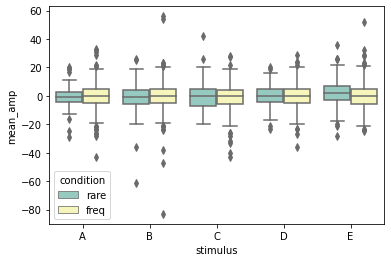

In [341]:
ax = sns.boxplot(x="stimulus", y="mean_amp", hue="condition",  data=all_peaks, palette="Set3")

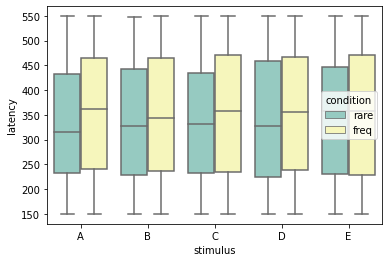

In [342]:
ax = sns.boxplot(x="stimulus", y="latency", hue="condition",  data=all_peaks, palette="Set3")

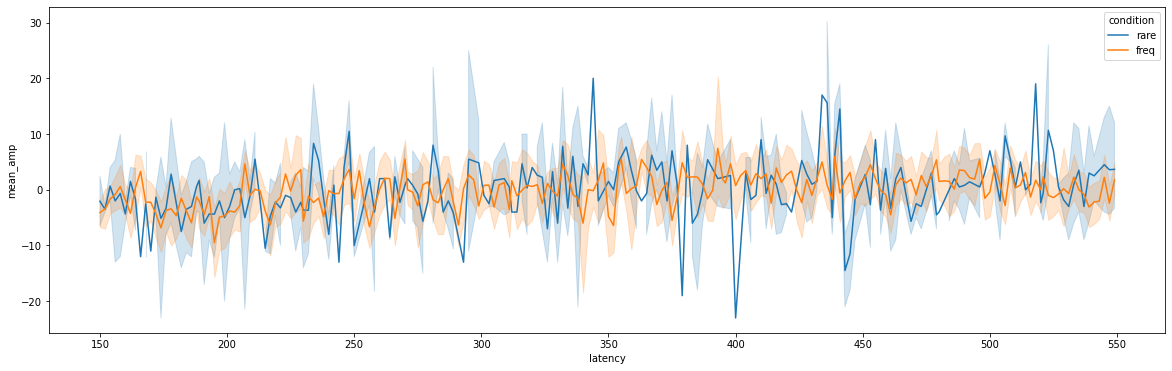

In [343]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6));
axs = sns.lineplot(x="latency", y="mean_amp", data=all_peaks, hue='condition')

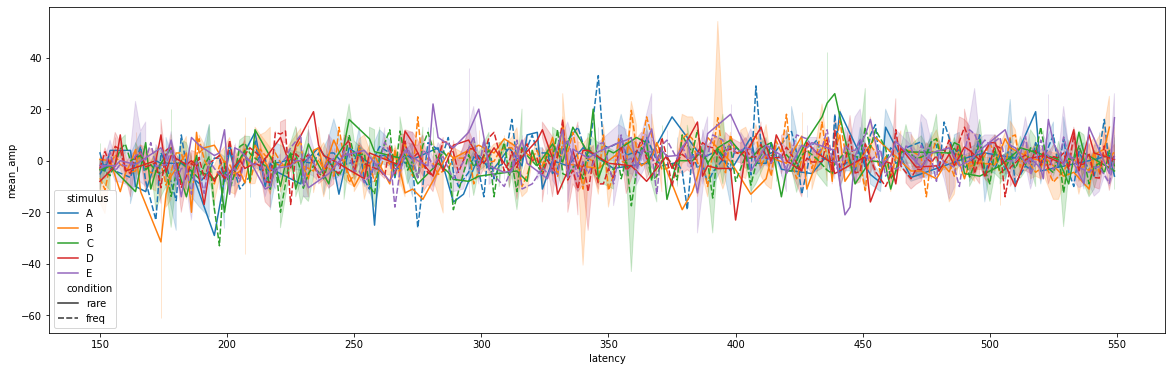

In [344]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6));
axs = sns.lineplot(x="latency", y="mean_amp", data=all_peaks, hue='stimulus', style="condition")

<AxesSubplot:xlabel='mean_amp', ylabel='Density'>

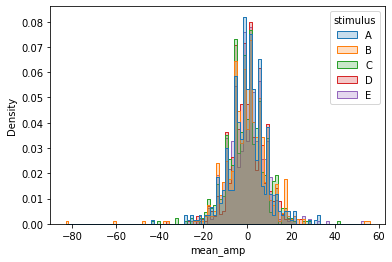

In [345]:
sns.histplot(
    all_peaks, x="mean_amp", hue="stimulus", element="step",
    stat="density", common_norm=False,
)

<AxesSubplot:xlabel='peak_amp', ylabel='Density'>

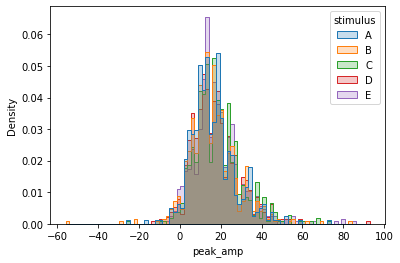

In [346]:
sns.histplot(
    all_peaks, x="peak_amp", hue="stimulus", element="step",
    stat="density", common_norm=False,
)